In [54]:
import numpy as np
import pandas as pd
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score # recall_score(y_true, y_pred, average='macro')
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

import shap

In [55]:
def is_kaggle_gpu_enabled():
    from tensorflow.python.client import device_lib
    return len(device_lib.list_local_devices()) > 2

In [56]:
train = pd.read_csv('../input/predicting-the-risk-cardiovascular-disease/train_dataset_train/train.csv', index_col=0)
test = pd.read_csv('../input/predicting-the-risk-cardiovascular-disease/test_dataset_test.csv', index_col=0)
sample_sub = pd.read_csv('../input/predicting-the-risk-cardiovascular-disease/train_dataset_train/sample_solution.csv')

In [57]:
remove_cols = ['ID_y']
target_cols = ['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',\
              'Прочие заболевания сердца']

cat_cols = [col for col in train.columns if train[col].dtype == 'O' and col != 'ID_y']

### replace nan's

In [58]:
# replace nan's
train['Пол'] = train['Пол'].fillna('м')
train['Возраст курения'] = train['Возраст курения'].fillna(0)
train['Сигарет в день'] = train['Сигарет в день'].fillna(0)
train['Частота пасс кур'] = train['Частота пасс кур'].fillna(0)
train['Возраст алког'] = train['Возраст алког'].fillna(0)

test['Возраст курения'] = test['Возраст курения'].fillna(0)
test['Сигарет в день'] = test['Сигарет в день'].fillna(0)
test['Частота пасс кур'] = test['Частота пасс кур'].fillna(0)
test['Возраст алког'] = test['Возраст алког'].fillna(0)

### New features

In [59]:
from datetime import datetime, time as datetime_time, timedelta

def time_diff(start, end):
    if isinstance(start, datetime_time): # convert to datetime
        assert isinstance(end, datetime_time)
        start, end = [datetime.combine(datetime.min, t) for t in [start, end]]
    if start <= end: # e.g., 10:33:26-11:15:49
        return end - start
    else: # end < start e.g., 23:55:00-00:25:00
        end += timedelta(1) # +day
        assert end > start
        return end - start
    
def compute_sleep_time(x):
    return time_diff(datetime.strptime(x['Время засыпания'], '%H:%M:%S'), datetime.strptime(x['Время пробуждения'], '%H:%M:%S')).seconds//3600

train['Время сна'] = train[['Время засыпания', 'Время пробуждения']].apply(lambda x: compute_sleep_time(x), axis=1)
test['Время сна'] = test[['Время засыпания', 'Время пробуждения']].apply(lambda x: compute_sleep_time(x), axis=1)

### Data

#### train test split

In [180]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=remove_cols + target_cols), train[target_cols], test_size=test_size, random_state=42)

Препроцессинг данных для MultiClass (не используется):

In [ ]:
# y_train = [re.sub(f' +', ',', re.sub(f'([\[\]])','', str(item)))  for item in [np.where(r==1)[0] for r in y_train.values]]
# y_test = [re.sub(f' +', ',', re.sub(f'([\[\]])','', str(item)))  for item in [np.where(r==1)[0] for r in y_test.values]]

# y_train = [item.join('5') if len(item) == 0 else item for item in y_train]
# y_test = [item.join('5') if len(item) == 0 else item for item in y_test]

# train_pool = Pool(X_train, [item for item in [np.where(r==1)[0] for r in y_train.values]], cat_features=cat_cols)
# val_pool = Pool(X_test, [item for item in [np.where(r==1)[0] for r in y_test.values]], cat_features=cat_cols)
# train_pool = Pool(X_train, y_train, cat_features=cat_cols)
# val_pool = Pool(X_test, y_test, cat_features=cat_cols)

# test_pool = Pool(test, cat_features=cat_cols)

# MultiLogloss
# class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8']

# base_model = CatBoostClassifier(iterations=1000,
#                            task_type="GPU",
#                            devices='0:1')
# base_model = CatBoostClassifier(iterations=1000, random_seed=43, loss_function='MultiClass', custom_metric=['Recall'])
# base_model = CatBoostClassifier(iterations=1000, random_seed=43, loss_function='MultiLogloss', custom_metric=['Recall']) # , auto_class_weights='Balanced'

# val_preds = [item[0] for item in val_preds]
# val_preds = [ast.literal_eval(item.replace(' ',',')) for item in val_preds]
# val_preds = [[5] if len(item) == 0 else item for item in val_preds]
# val_preds = MultiLabelBinarizer(classes=[0,1,2,3,4,5]).fit_transform(val_preds)[:,0:5]

In [71]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.show()

### Model / Train

Предсказание целевых переменных по отдельности

0:	learn: 0.6893697	test: 0.6895835	best: 0.6895835 (0)	total: 4.17ms	remaining: 4.17s
750:	learn: 0.4224799	test: 0.5500973	best: 0.5496391 (684)	total: 2.27s	remaining: 754ms
999:	learn: 0.3829953	test: 0.5545844	best: 0.5496391 (684)	total: 3.07s	remaining: 0us

bestTest = 0.5496391211
bestIteration = 684

Shrink model to first 685 iterations.
recall:  0.7229538374398188


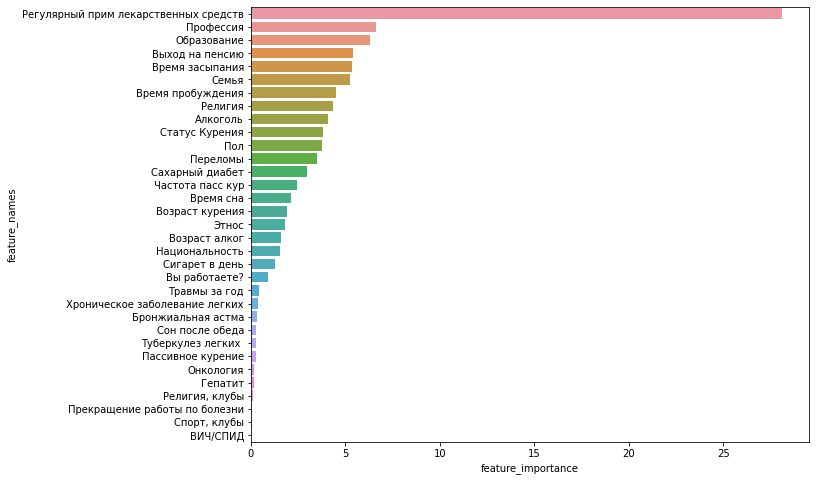

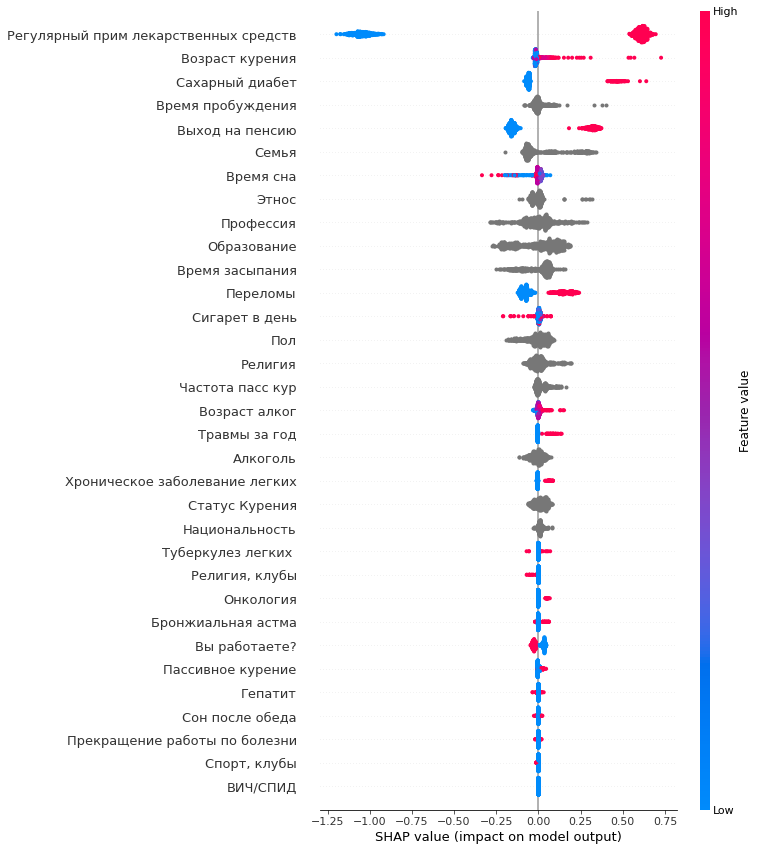

0:	learn: 0.6923265	test: 0.6933070	best: 0.6933070 (0)	total: 3.73ms	remaining: 3.73s
750:	learn: 0.1196264	test: 0.8997221	best: 0.6292061 (312)	total: 2.18s	remaining: 724ms
999:	learn: 0.0682783	test: 1.2329265	best: 0.6292061 (312)	total: 2.97s	remaining: 0us

bestTest = 0.6292060767
bestIteration = 312

Shrink model to first 313 iterations.
recall:  0.5648471615720524


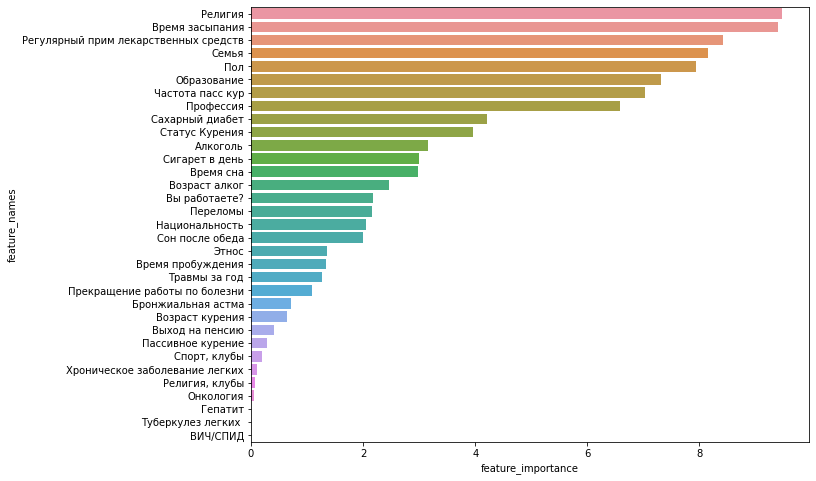

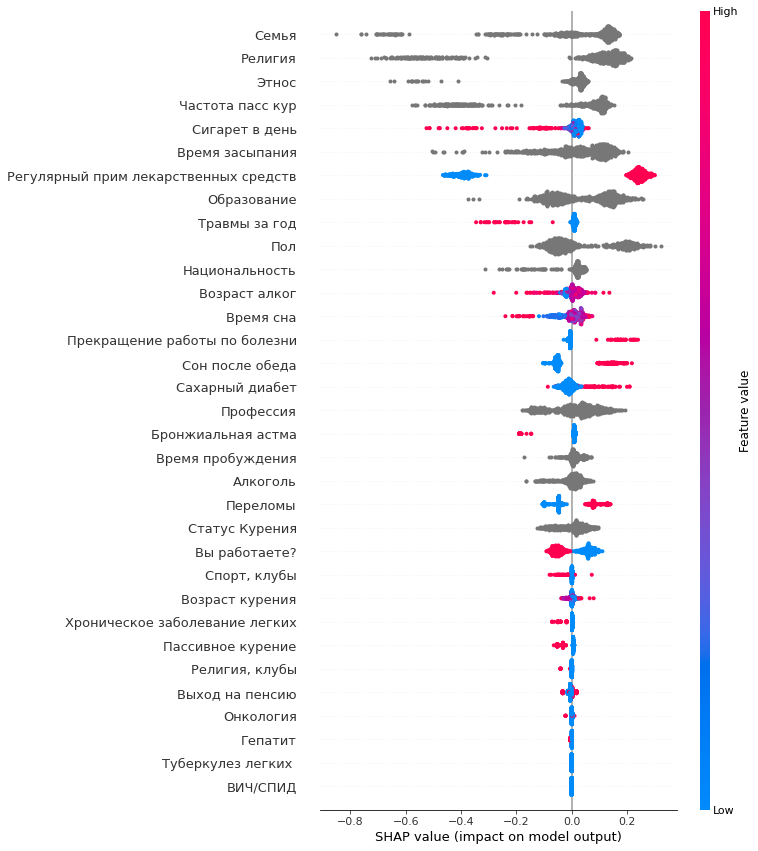

0:	learn: 0.6901518	test: 0.6908689	best: 0.6908689 (0)	total: 3.77ms	remaining: 3.76s
750:	learn: 0.2964542	test: 0.8510736	best: 0.6512095 (47)	total: 2.38s	remaining: 787ms
999:	learn: 0.2446771	test: 0.9299764	best: 0.6512095 (47)	total: 3.24s	remaining: 0us

bestTest = 0.6512095272
bestIteration = 47

Shrink model to first 48 iterations.
recall:  0.582695374800638


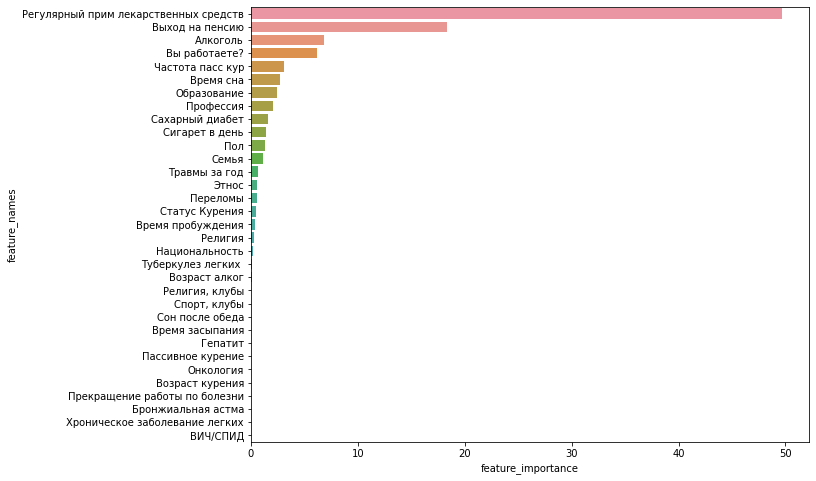

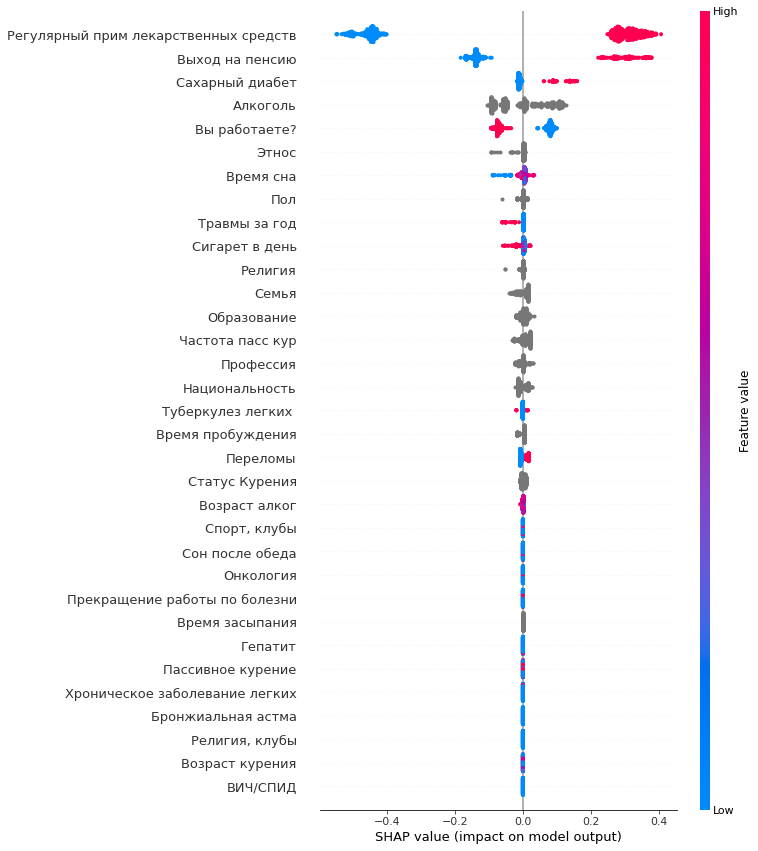

0:	learn: 0.6906909	test: 0.6912605	best: 0.6912605 (0)	total: 5.73ms	remaining: 5.72s
750:	learn: 0.3025542	test: 0.6536378	best: 0.6204148 (187)	total: 2.2s	remaining: 728ms
999:	learn: 0.2381474	test: 0.6521900	best: 0.6204148 (187)	total: 2.98s	remaining: 0us

bestTest = 0.6204148285
bestIteration = 187

Shrink model to first 188 iterations.
recall:  0.6198150224215246


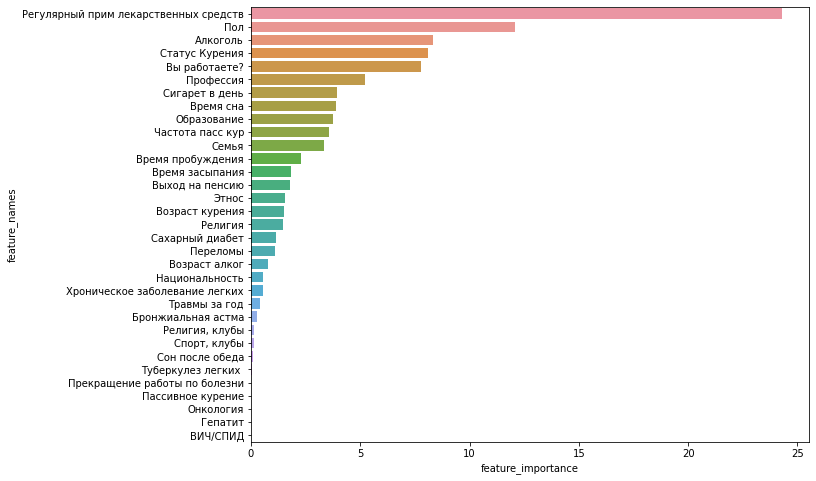

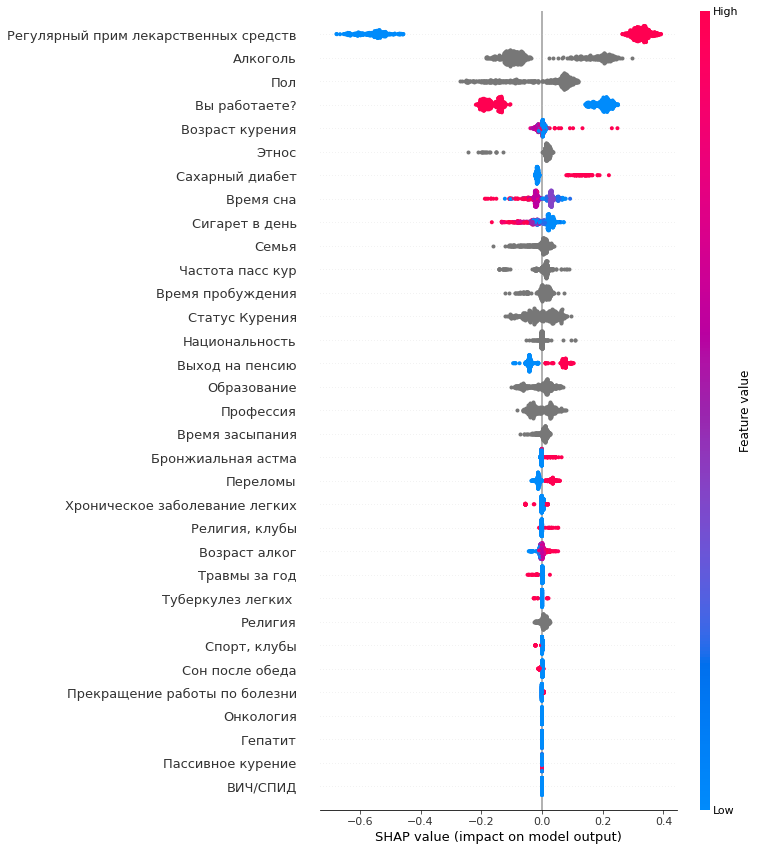

0:	learn: 0.6919146	test: 0.6925375	best: 0.6925375 (0)	total: 3.61ms	remaining: 3.61s
750:	learn: 0.2987506	test: 0.8016002	best: 0.6765802 (145)	total: 2.22s	remaining: 735ms
999:	learn: 0.2315545	test: 0.8763012	best: 0.6765802 (145)	total: 2.98s	remaining: 0us

bestTest = 0.6765802347
bestIteration = 145

Shrink model to first 146 iterations.
recall:  0.5480922098569158


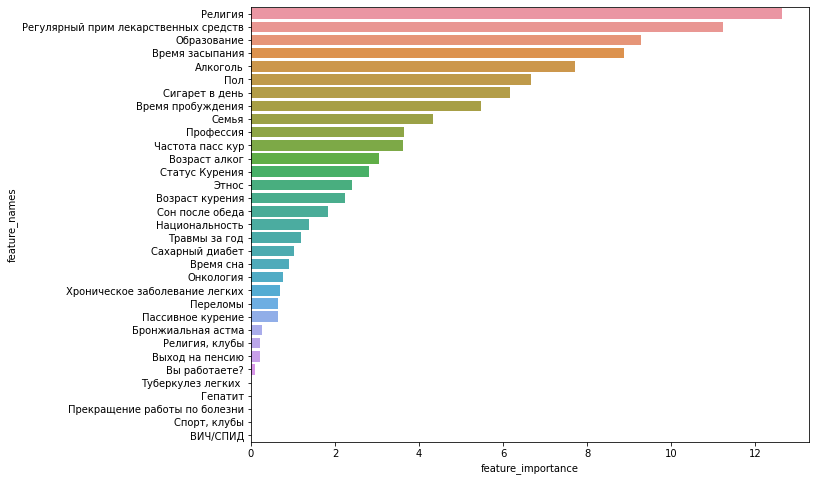

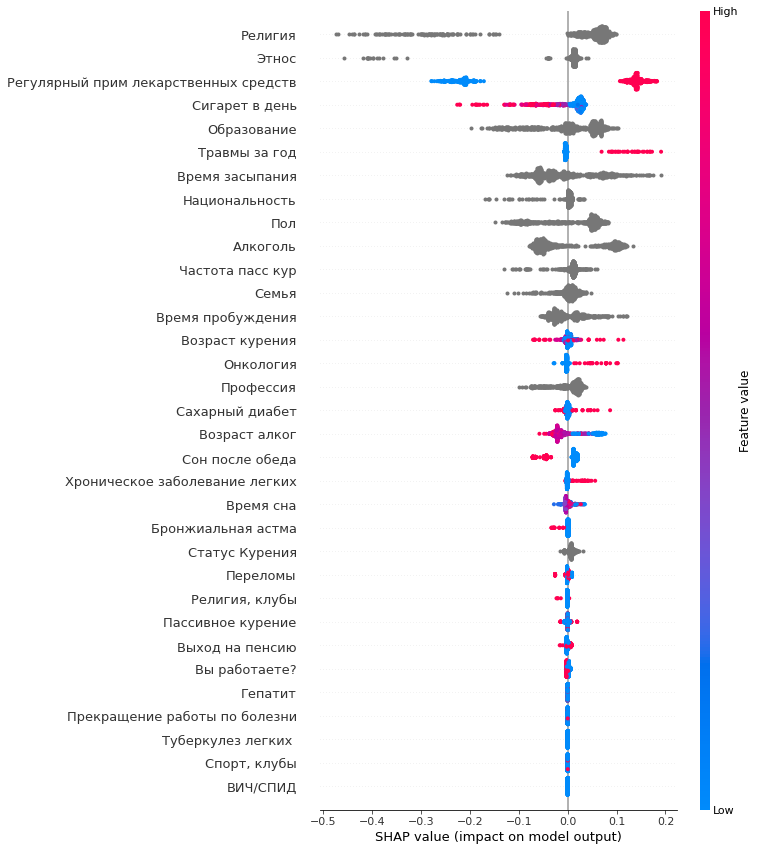

In [86]:
val_preds = []
val_probas = []
test_preds = []
test_probas = []
recall_all = []

for i in range(0,5):
    train_pool = Pool(X_train, y_train.iloc[:, i], cat_features=cat_cols)
    val_pool = Pool(X_test, y_test.iloc[:, i], cat_features=cat_cols)
    test_pool = Pool(test, cat_features=cat_cols)
    
    base_model = CatBoostClassifier(iterations=1000, random_seed=43, custom_metric=['Recall'], auto_class_weights='Balanced', \
                                   depth=4, rsm=1, random_strength=1, l2_leaf_reg=1, learning_rate=0.015)
    base_model.fit(train_pool, verbose=750, eval_set=val_pool, use_best_model=True) 
    
    val_pred = base_model.predict(val_pool)
    val_proba = base_model.predict_proba(val_pool)
    val_probas.append(val_proba)
    recall = recall_score(y_test.iloc[:, i].values, val_pred , average='macro')
    recall_all.append(recall)
    print('recall: ', recall)
    val_preds.append(val_pred)
    
    test_pred = base_model.predict(test_pool)
    test_proba = base_model.predict_proba(test_pool)
    test_preds.append(test_pred)
    test_probas.append(test_proba)
    
    plot_feature_importance(base_model.get_feature_importance(), X_train.columns)
    
    explainer = shap.Explainer(base_model)
    shap_values = explainer(X_train)
    shap.plots.beeswarm(shap_values, max_display=40, order=shap_values.abs.max(0))
    plt.show()
    

In [100]:
print('Recall', sum(recall_all) / len(recall_all))

Recall 0.6076807212181901


In [ ]:
# base_model.get_all_params()

Подбор порогов для Multilabel (не используется)

In [ ]:
# val_pred_c = np.where(val_probas[0][:,1] > 0.534, 1, 0)
# val_pred_c = np.where(val_probas[1][:,1] > 0.529, 1, 0)
# val_pred_c = np.where(val_probas[2][:,1] > 0.513, 1, 0)
# val_pred_c = np.where(val_probas[3][:,1] > 0.512, 1, 0)
# val_pred_c = np.where(val_probas[4][:,1] > 0.497, 1, 0)
# recall_score(y_test.iloc[:, 4].values, val_pred_c , average='macro')

Попробовал простые модели:

In [ ]:
# for col in X_train.columns:
#     if  X_train[col].dtype == 'O':
#         X_train[col] = X_train[col].astype('category').cat.codes
# for col in X_test.columns:
#     if  X_test[col].dtype == 'O':
#         X_test[col] = X_test[col].astype('category').cat.codes

RandomForest

In [ ]:
# clf = RandomForestClassifier(max_depth=14, n_estimators=2000, random_state=0, class_weight="balanced") # 15 750 0 class
# clf.fit(X_train, y_train.iloc[:, 0].values)
# preds = clf.predict(X_test)
# recall_score(y_test.iloc[:, 0].values, preds , average='macro')

Ridge

In [ ]:
# sc = StandardScaler()
# clf = RidgeClassifier(alpha=2.0)
# clf.fit(sc.fit_transform(X_train), y_train.iloc[:, 0])
# preds = clf.predict(sc.transform(X_test))
# recall_score(y_test.iloc[:, 0].values, preds , average='macro')

ExtraTrees

In [ ]:
# clf = ExtraTreesClassifier(max_depth=15, n_estimators=2650, random_state=0, class_weight='balanced')
# clf.fit(X_train, y_train.iloc[:, 1].values)
# preds = clf.predict(X_test)
# recall_score(y_test.iloc[:, 1].values, preds , average='macro')

### Submit

In [98]:
assert len(test_preds) == 5
assert test_preds[0].shape == (638,)

sample_sub['Артериальная гипертензия'] = test_preds[0]
sample_sub['ОНМК'] = test_preds[1]
sample_sub['Стенокардия, ИБС, инфаркт миокарда'] = test_preds[2]
sample_sub['Сердечная недостаточность'] = test_preds[3]
sample_sub['Прочие заболевания сердца'] = test_preds[4]
sample_sub.to_csv("base_one_vs.csv", index=False)

# Step by Step pred (Финальная модель)

val Recall получается завышенным, т.к. для обучения используется оригинальные целевые переменные, а не предсказанные, как при тестовом предсказании.

Я пробовал учить финальную модель на всем датасете, но в этом случае происходит сильное переобучение, т.к. нельзя использовать early stopping.

0:	learn: 0.6892620	test: 0.6897744	best: 0.6897744 (0)	total: 3.67ms	remaining: 3.67s
750:	learn: 0.4140848	test: 0.5500879	best: 0.5482929 (643)	total: 2.36s	remaining: 781ms
999:	learn: 0.3748678	test: 0.5489753	best: 0.5482929 (643)	total: 3.16s	remaining: 0us

bestTest = 0.5482929245
bestIteration = 643

Shrink model to first 644 iterations.
recall:  0.7456694188117209


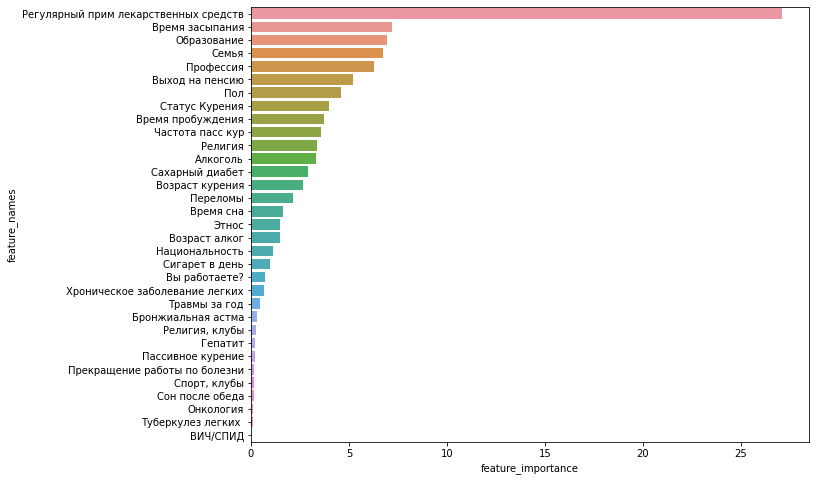

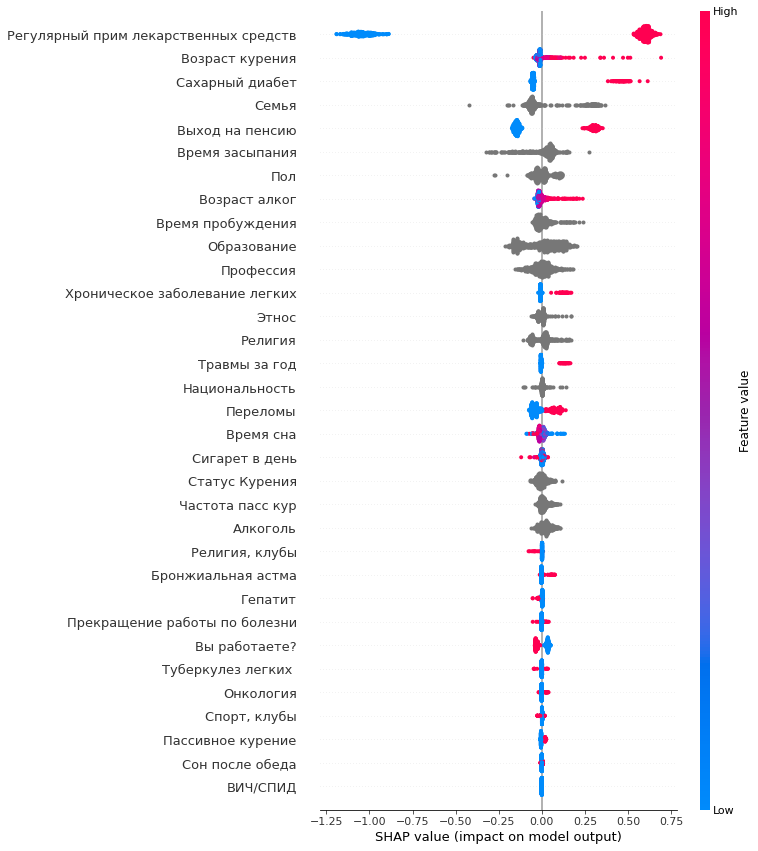

In [184]:
recall_all = []

train_pool = Pool(X_train, y_train.iloc[:, 0], cat_features=cat_cols)
val_pool = Pool(X_test, y_test.iloc[:, 0], cat_features=cat_cols)
test_pool = Pool(test, cat_features=cat_cols)

base_model_1 = CatBoostClassifier(iterations=1000, random_seed=43, custom_metric=['Recall'], auto_class_weights='Balanced', \
                               depth=4, rsm=1, random_strength=1, l2_leaf_reg=1, learning_rate=0.015)
base_model_1.fit(train_pool, verbose=750, eval_set=val_pool, use_best_model=True)
val_pred = base_model_1.predict(val_pool)
recall = recall_score(y_test.iloc[:, 0].values, val_pred , average='macro')
recall_all.append(recall)
print('recall: ', recall)

plot_feature_importance(base_model_1.get_feature_importance(), X_train.columns)
explainer = shap.Explainer(base_model_1)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, max_display=40, order=shap_values.abs.max(0))

0:	learn: 0.6909136	test: 0.6912727	best: 0.6912727 (0)	total: 3.84ms	remaining: 3.83s
750:	learn: 0.0967784	test: 1.2607974	best: 0.6825725 (24)	total: 2.13s	remaining: 707ms
999:	learn: 0.0527677	test: 1.6215010	best: 0.6825725 (24)	total: 2.91s	remaining: 0us

bestTest = 0.6825725381
bestIteration = 24

Shrink model to first 25 iterations.
recall:  0.5708333333333333


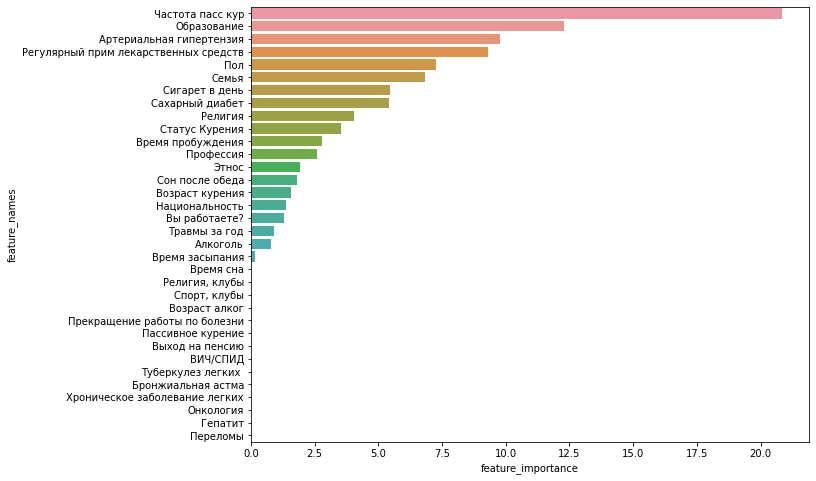

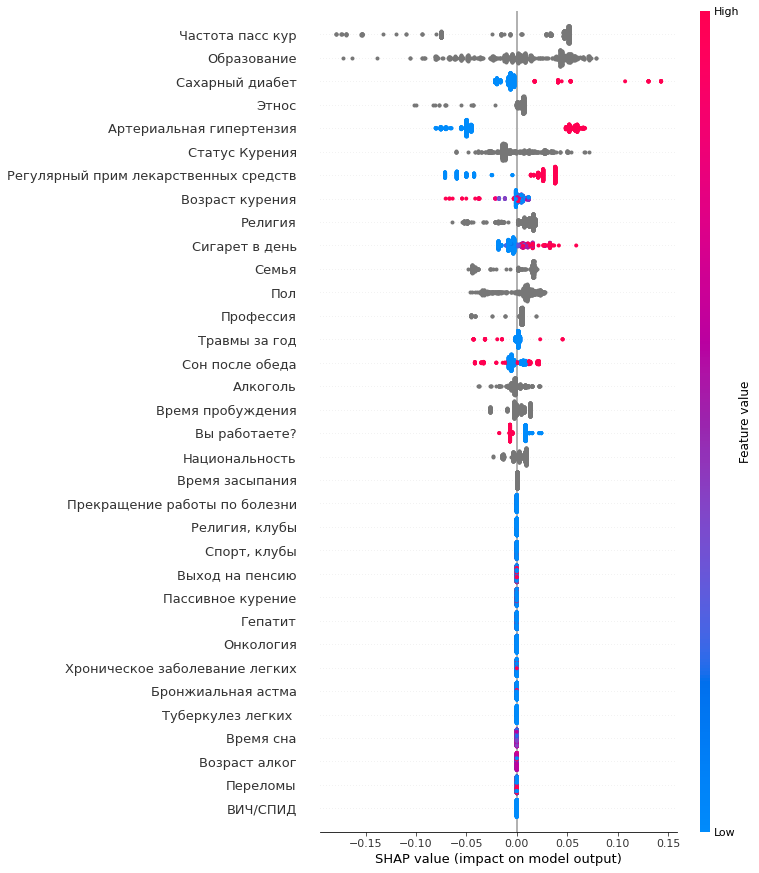

In [185]:
train_pool = Pool(pd.concat([X_train,y_train.iloc[:, 0]], axis=1), y_train.iloc[:, 1], cat_features=cat_cols)
val_pool = Pool(pd.concat([X_test, y_test.iloc[:, 0]], axis=1), y_test.iloc[:, 1], cat_features=cat_cols)

base_model_2 = CatBoostClassifier(iterations=1000, random_seed=43, custom_metric=['Recall'], auto_class_weights='Balanced', \
                               depth=4, rsm=1, random_strength=1, l2_leaf_reg=1, learning_rate=0.015)
base_model_2.fit(train_pool, verbose=750, eval_set=val_pool, use_best_model=True) 
val_pred = base_model_2.predict(val_pool)
recall = recall_score(y_test.iloc[:, 1].values, val_pred , average='macro')
recall_all.append(recall)
print('recall: ', recall)

plot_feature_importance(base_model_2.get_feature_importance(), pd.concat([X_train,y_train.iloc[:, 0]], axis=1).columns)
explainer = shap.Explainer(base_model_2)
shap_values = explainer(pd.concat([X_train,y_train.iloc[:, 0]], axis=1))
shap.plots.beeswarm(shap_values, max_display=40, order=shap_values.abs.max(0))

0:	learn: 0.6867370	test: 0.6876200	best: 0.6876200 (0)	total: 3.2ms	remaining: 3.19s
750:	learn: 0.2669701	test: 0.7097955	best: 0.5894199 (93)	total: 2.22s	remaining: 738ms
999:	learn: 0.2155614	test: 0.7573363	best: 0.5894199 (93)	total: 3.02s	remaining: 0us

bestTest = 0.5894198754
bestIteration = 93

Shrink model to first 94 iterations.
recall:  0.6887438674442286


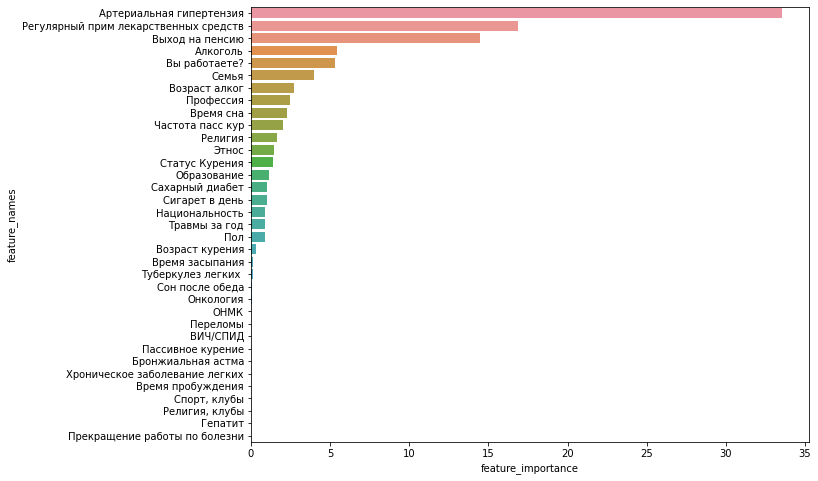

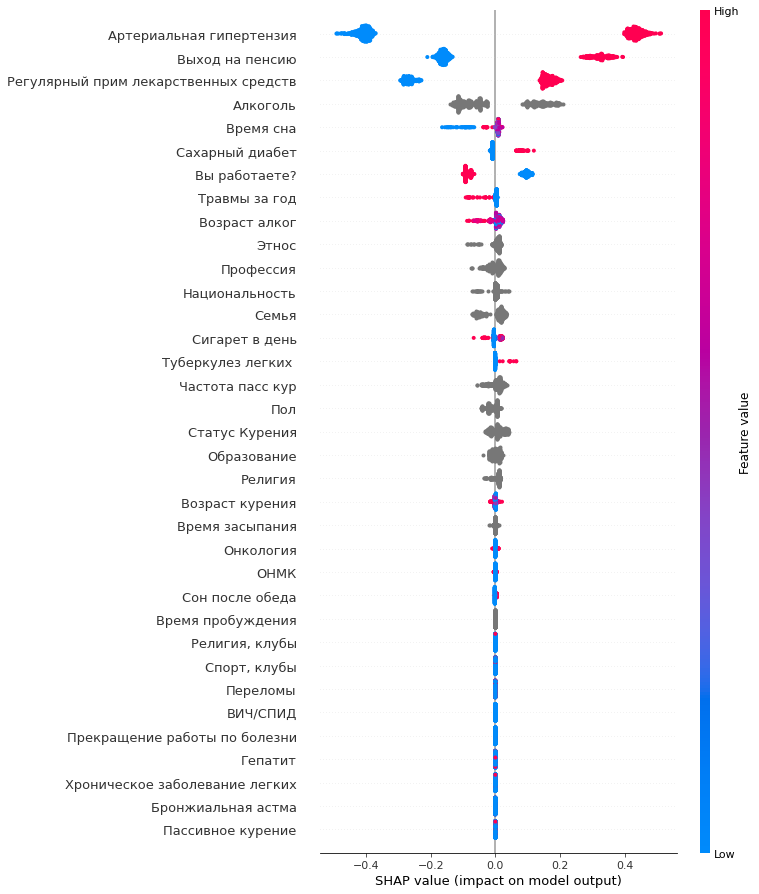

In [186]:
train_pool = Pool(pd.concat([X_train,y_train.iloc[:, 0:2]], axis=1), y_train.iloc[:, 2], cat_features=cat_cols)
val_pool = Pool(pd.concat([X_test, y_test.iloc[:, 0:2]], axis=1), y_test.iloc[:, 2], cat_features=cat_cols)

base_model_3 = CatBoostClassifier(iterations=1000, random_seed=43, custom_metric=['Recall'], auto_class_weights='Balanced', \
                               depth=4, rsm=1, random_strength=1, l2_leaf_reg=1, learning_rate=0.015)
base_model_3.fit(train_pool, verbose=750, eval_set=val_pool, use_best_model=True) 
val_pred = base_model_3.predict(val_pool)
recall = recall_score(y_test.iloc[:, 2].values, val_pred , average='macro')
recall_all.append(recall)
print('recall: ', recall)

plot_feature_importance(base_model_3.get_feature_importance(), pd.concat([X_train,y_train.iloc[:, 0:2]], axis=1).columns)
explainer = shap.Explainer(base_model_3)
shap_values = explainer(pd.concat([X_train,y_train.iloc[:, 0:2]], axis=1))
shap.plots.beeswarm(shap_values, max_display=40, order=shap_values.abs.max(0))

0:	learn: 0.6846579	test: 0.6848842	best: 0.6848842 (0)	total: 3.3ms	remaining: 3.3s
750:	learn: 0.1646757	test: 0.4671551	best: 0.4473970 (384)	total: 2.49s	remaining: 825ms
999:	learn: 0.1242912	test: 0.4886975	best: 0.4473970 (384)	total: 3.3s	remaining: 0us

bestTest = 0.4473969959
bestIteration = 384

Shrink model to first 385 iterations.
recall:  0.7650171821305842


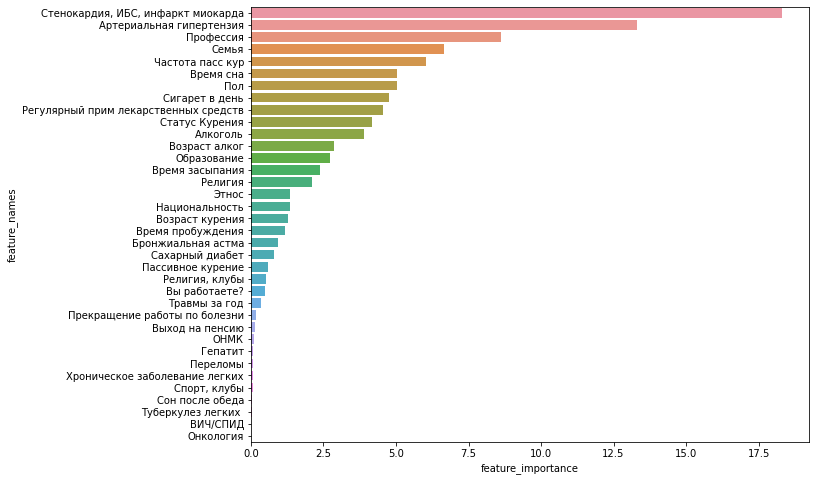

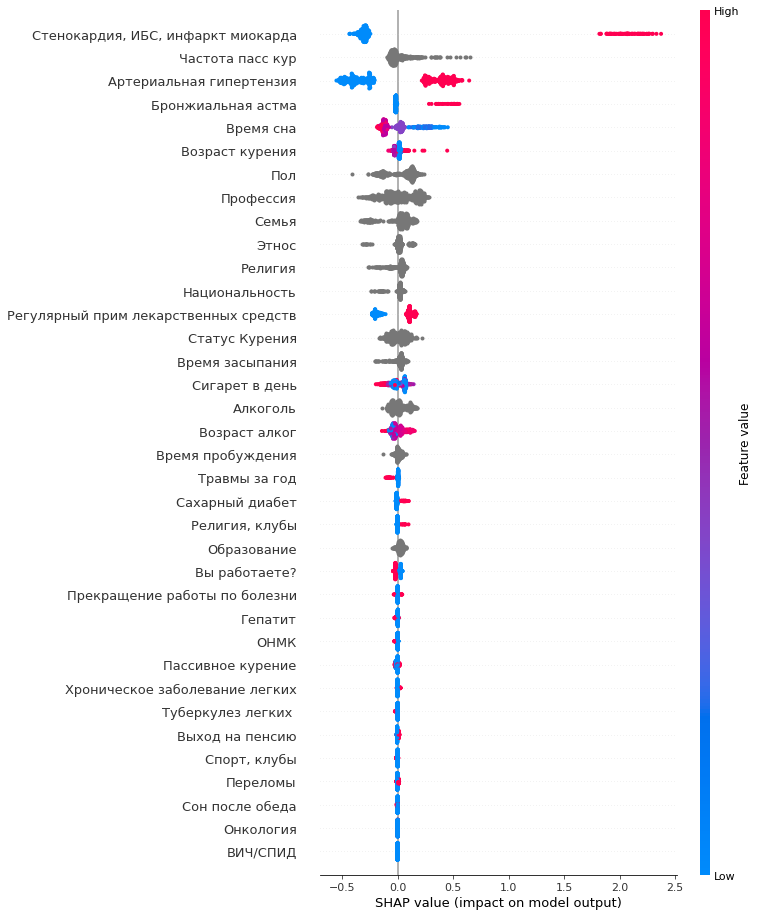

In [187]:
train_pool = Pool(pd.concat([X_train,y_train.iloc[:, 0:3]], axis=1), y_train.iloc[:, 3], cat_features=cat_cols)
val_pool = Pool(pd.concat([X_test, y_test.iloc[:, 0:3]], axis=1), y_test.iloc[:, 3], cat_features=cat_cols)

base_model_4 = CatBoostClassifier(iterations=1000, random_seed=43, custom_metric=['Recall'], auto_class_weights='Balanced', \
                               depth=4, rsm=1, random_strength=1, l2_leaf_reg=1, learning_rate=0.015)
base_model_4.fit(train_pool, verbose=750, eval_set=val_pool, use_best_model=True) 
val_pred = base_model_4.predict(val_pool)
recall = recall_score(y_test.iloc[:, 3].values, val_pred , average='macro')
recall_all.append(recall)
print('recall: ', recall)

plot_feature_importance(base_model_4.get_feature_importance(), pd.concat([X_train,y_train.iloc[:, 0:3]], axis=1).columns)
explainer = shap.Explainer(base_model_4)
shap_values = explainer(pd.concat([X_train,y_train.iloc[:, 0:3]], axis=1))
shap.plots.beeswarm(shap_values, max_display=40, order=shap_values.abs.max(0))

0:	learn: 0.6915881	test: 0.6929302	best: 0.6929302 (0)	total: 5.58ms	remaining: 5.57s
750:	learn: 0.2665320	test: 0.8032482	best: 0.6777341 (86)	total: 2.31s	remaining: 766ms
999:	learn: 0.2026255	test: 0.8800859	best: 0.6777341 (86)	total: 3.11s	remaining: 0us

bestTest = 0.6777341475
bestIteration = 86

Shrink model to first 87 iterations.
recall:  0.5175257731958763


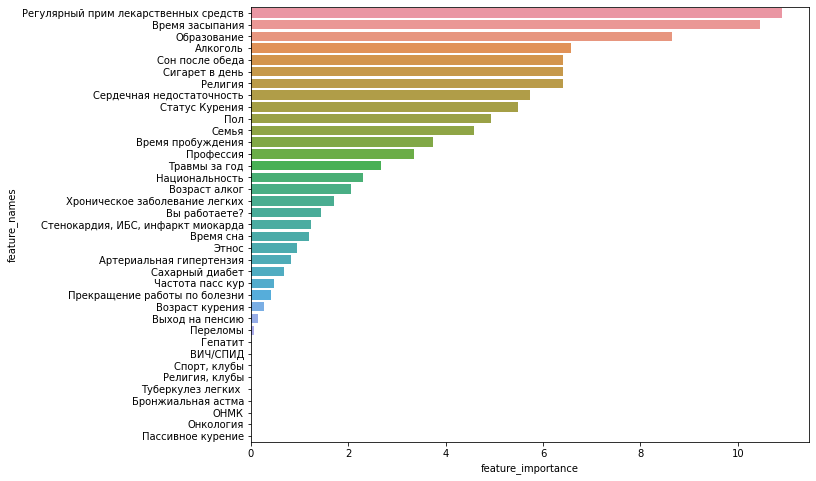

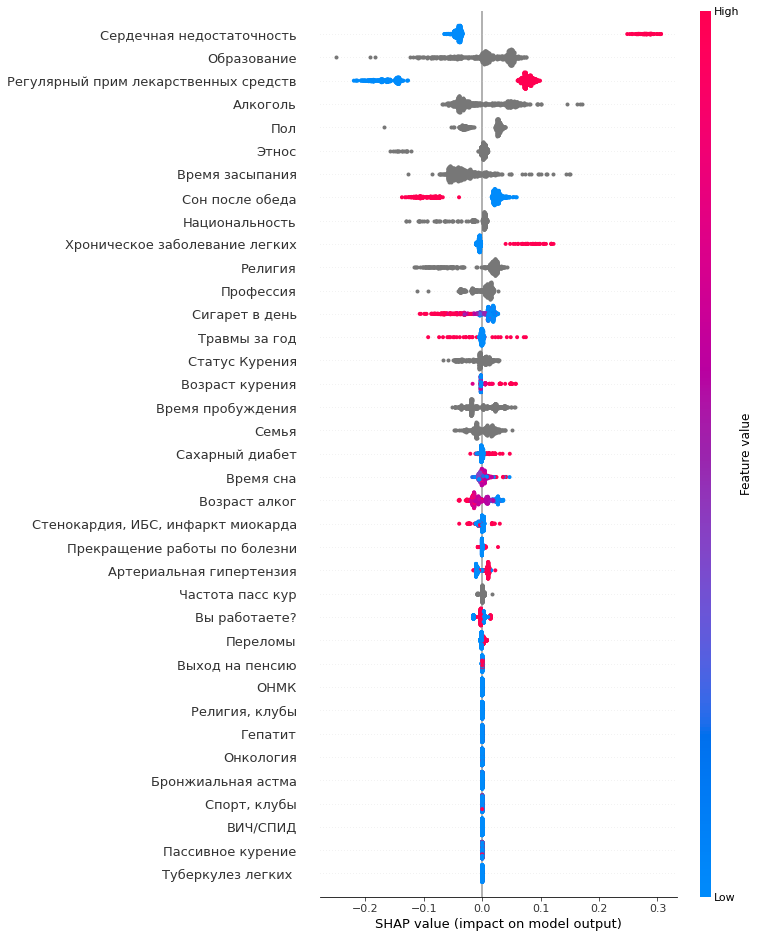

In [188]:
train_pool = Pool(pd.concat([X_train,y_train.iloc[:, 0:4]], axis=1), y_train.iloc[:, 4], cat_features=cat_cols)
val_pool = Pool(pd.concat([X_test, y_test.iloc[:, 0:4]], axis=1), y_test.iloc[:, 4], cat_features=cat_cols)

base_model_5 = CatBoostClassifier(iterations=1000, random_seed=43, custom_metric=['Recall'], auto_class_weights='Balanced', \
                               depth=4, rsm=1, random_strength=1, l2_leaf_reg=1, learning_rate=0.015)
base_model_5.fit(train_pool, verbose=750, eval_set=val_pool, use_best_model=True) 
val_pred = base_model_5.predict(val_pool)
recall = recall_score(y_test.iloc[:, 4].values, val_pred , average='macro')
recall_all.append(recall)
print('recall: ', recall)

plot_feature_importance(base_model_5.get_feature_importance(), pd.concat([X_train,y_train.iloc[:, 0:4]], axis=1).columns)
explainer = shap.Explainer(base_model_5)
shap_values = explainer(pd.concat([X_train,y_train.iloc[:, 0:4]], axis=1))
shap.plots.beeswarm(shap_values, max_display=40, order=shap_values.abs.max(0))

На последнем шаге Recall оказался ниже, чем при использовании независимого предсказания переменных, возможно модель переобучилась и для последнего шага стоит использовать модель обученную только на независимых переменных.

In [189]:
print('Recall', sum(recall_all) / len(recall_all))

Recall 0.6575579149831486


# predict test

In [190]:
test_pool = Pool(test, cat_features=cat_cols)
test_preds_1 = base_model_1.predict(test_pool)

test_1 = test.copy()
test_1['Артериальная гипертензия'] = test_preds_1

test_pool = Pool(test_1, cat_features=cat_cols)
test_preds_2 = base_model_2.predict(test_pool)

In [191]:
test_1['ОНМК'] = test_preds_2
test_pool = Pool(test_1, cat_features=cat_cols)
test_preds_3 = base_model_3.predict(test_pool)

In [192]:
test_1['Стенокардия, ИБС, инфаркт миокарда'] = test_preds_3
test_pool = Pool(test_1, cat_features=cat_cols)
test_preds_4 = base_model_4.predict(test_pool)

In [193]:
test_1['Сердечная недостаточность'] = test_preds_4
test_pool = Pool(test_1, cat_features=cat_cols)
test_preds_5 = base_model_5.predict(test_pool)

In [194]:
sample_sub['Артериальная гипертензия'] = test_preds_1
sample_sub['ОНМК'] = test_preds_2
sample_sub['Стенокардия, ИБС, инфаркт миокарда'] = test_preds_3
sample_sub['Сердечная недостаточность'] = test_preds_4
sample_sub['Прочие заболевания сердца'] = test_preds_5
sample_sub.to_csv("base_step_by_step.csv", index=False)